In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
# import tensorflow as tf

In [2]:
data = pd.read_csv('./data/consumo.csv', encoding="utf-8", thousands=".", decimal=",")
print(data.shape)
data.head(7)

(3073, 15)


,AÑO,MES,Fecha,Tipo día,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,NORESTE,COMAHUE,PATAGONICA,DEMANDA TOTAL,TEMPERATURA REFERENCIA MEDIA GBA °C
0,2017,ene-17,1/1/2017,Domingo o Feriado,6352.7,1472.3,1134.4,1766.6,903.1,1602.1,1400.3,561.2,500.9,15693.7,31.3
1,2017,ene-17,2/1/2017,Lunes habiles,6617.9,1779.4,1363.5,1963.9,1091.8,1627.6,1585.6,638.8,540.6,17209.2,25.4
2,2017,ene-17,3/1/2017,Martes Habiles,6678.0,1889.0,1600.7,2036.3,1178.7,1806.5,1653.0,624.6,536.5,18003.4,25.5
3,2017,ene-17,4/1/2017,Miercoles habiles,6427.0,1840.6,1356.4,1756.6,1078.9,1759.9,1604.8,598.4,528.9,16951.5,27.0
4,2017,ene-17,5/1/2017,Jueves Habiles,5874.0,1770.9,1366.0,1848.4,1037.8,1403.5,1228.3,585.2,524.7,15638.8,21.9
5,2017,ene-17,6/1/2017,Viernes habiles,5781.1,1801.1,1367.4,1929.8,1135.5,1354.6,1218.7,615.5,550.9,15754.5,24.3
6,2017,ene-17,7/1/2017,Sabado o Semilaborable,6231.7,1862.7,1388.8,2042.9,1161.9,1425.7,1306.4,626.4,533.9,16580.5,29.1


In [3]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
data.set_index('Fecha', inplace=True)
data['DEMANDA TOTAL'] = data['DEMANDA TOTAL'].astype(float)

In [4]:
# Analizar si hay campos nulos
print(data.isnull().sum())
# Ver cuantas filas tiene y calcular la cantidad de días entre el último y el primero
print('Datos totales', data.shape[0])
print('Cantidad de días', (data.index[-1] - data.index[0]).days)

AÑO                                    0
MES                                    0
Tipo día                               0
GRAN BS.AS.                            0
BUENOS AIRES                           0
CENTRO                                 0
LITORAL                                0
CUYO                                   0
NOROESTE                               0
NORESTE                                0
COMAHUE                                0
PATAGONICA                             0
DEMANDA TOTAL                          0
TEMPERATURA REFERENCIA MEDIA GBA °C    0
dtype: int64
Datos totales 3073
Cantidad de días 3072


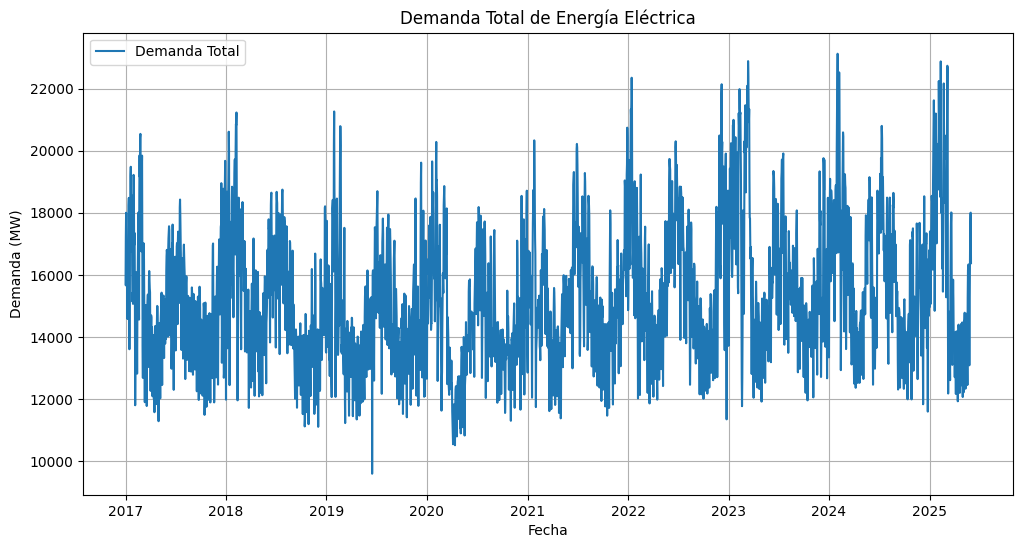

In [5]:
# Visualización de la serie temporal completa
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['DEMANDA TOTAL'], label='Demanda Total', color='tab:blue')
plt.title('Demanda Total de Energía Eléctrica')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid()
plt.show()

In [6]:
# Ubicamos el pico bajo de demanda
idxmindata = data['DEMANDA TOTAL'].idxmin().date()
print(f"Fecha del pico bajo de demanda: {idxmindata}")
# Causa: "Apagón del siglo"

Fecha del pico bajo de demanda: 2019-06-16


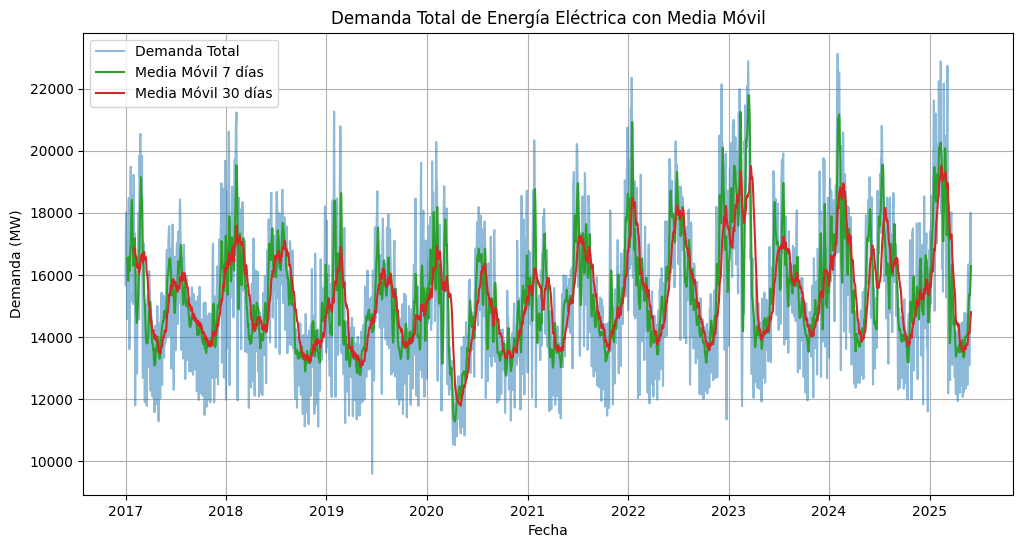

In [7]:
# Filtro de media móvil 
def moving_average_filter(data, window_size):
    return data.rolling(window=window_size).mean()
# Aplicar filtro de media móvil
data['MA7'] = moving_average_filter(data['DEMANDA TOTAL'], 7).dropna()
data['MA15'] = moving_average_filter(data['DEMANDA TOTAL'], 15).dropna()
data['MA30'] = moving_average_filter(data['DEMANDA TOTAL'], 30).dropna()

# Visualización de la serie temporal con media móvil
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['DEMANDA TOTAL'], label='Demanda Total', color='tab:blue', alpha=0.5)
plt.plot(data.index, data['MA7'], label='Media Móvil 7 días', color='tab:green')
plt.plot(data.index, data['MA30'], label='Media Móvil 30 días', color='tab:red')
plt.title('Demanda Total de Energía Eléctrica con Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid()
plt.show()

In [8]:
def test_stationarity(series, method='adf', alpha=0.05):
    if method.lower() == 'adf':
        result = adfuller(series)
        if result[1] <= alpha:
            print("[ADF]\tLa serie es estacionaria")
        else:
            print("[ADF]\tLa serie no es estacionaria")
    elif method.lower() == 'kpss':
        result = kpss(series, regression='c')
        if result[1] <= alpha:
            print("[KPSS]\tLa serie no es estacionaria")
        else:
            print("[KPSS]\tLa serie es estacionaria")
    else:
        raise ValueError("Método no reconocido. Usar 'adf' o 'kpss'.")
    print(f"[{method.upper()}]\tp-value:", result[1])


In [9]:
test_stationarity(data['DEMANDA TOTAL'], method='ADF', alpha=0.05)
test_stationarity(data['DEMANDA TOTAL'], method='KPSS', alpha=0.05)
test_stationarity(data['MA30'].dropna(), method='ADF', alpha=0.05)
test_stationarity(data['MA30'].dropna(), method='KPSS', alpha=0.05)
# El warning de KPSS indica que el p-valor es muy pequeño, lo que sugiere que la serie no es estacionaria.

[ADF]	La serie es estacionaria
[ADF]	p-value: 7.94830966913703e-08
[KPSS]	La serie no es estacionaria
[KPSS]	p-value: 0.01


/tmp/ipykernel_117517/1903299311.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


[ADF]	La serie es estacionaria
[ADF]	p-value: 5.317534358744256e-05
[KPSS]	La serie no es estacionaria
[KPSS]	p-value: 0.01


/tmp/ipykernel_117517/1903299311.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


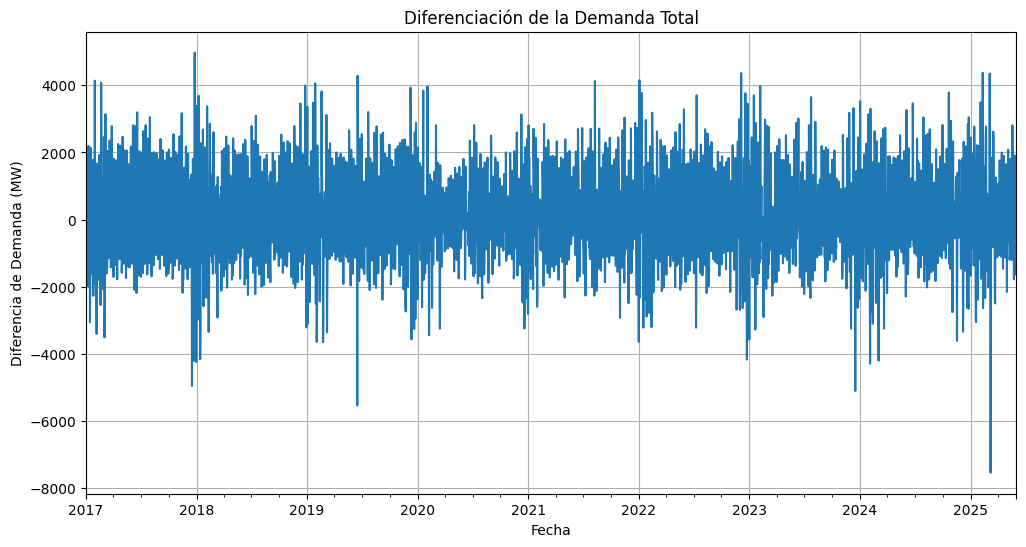

In [10]:
# Diferenciación para hacer la serie estacionaria
data['DEMANDA TOTAL Diff'] = data['DEMANDA TOTAL'].diff().dropna()
data['DEMANDA TOTAL Diff'].plot(figsize=(12, 6), title='Diferenciación de la Demanda Total')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Demanda (MW)')
plt.grid()
plt.show()

In [11]:
# Ubicamos el pico bajo de demanda después de la diferenciación
idxmindata_diff = data['DEMANDA TOTAL Diff'].idxmin().date()
print(f"Fecha del pico bajo de demanda después de la diferenciación: {idxmindata_diff}")

Fecha del pico bajo de demanda después de la diferenciación: 2025-03-08


In [12]:
# Re-test stationarity after differencing
test_stationarity(data['DEMANDA TOTAL Diff'].dropna(), method='ADF', alpha=0.05)
test_stationarity(data['DEMANDA TOTAL Diff'].dropna(), method='KPSS', alpha=0.05)
# El warning de KPSS indica que el p-valor es muy grande, lo que sugiere que la serie es altamente estacionaria (como ruido blanco).

[ADF]	La serie es estacionaria
[ADF]	p-value: 6.691596417420544e-24
[KPSS]	La serie es estacionaria
[KPSS]	p-value: 0.1


/tmp/ipykernel_117517/1903299311.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')


In [13]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(data['MA30']) * 0.8)
train, test = data['MA30'][:train_size], data['MA30'][train_size:]
test_size = len(test)
print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de prueba: {len(test)}")

Tamaño del conjunto de entrenamiento: 2458
Tamaño del conjunto de prueba: 615


In [14]:
# Ajustar el modelo ARIMA
# model = ARIMA(train.dropna(), order=(5, 1, 28))  # ARIMA(p, d, q) with p=1, d=0, q=1
# AutoARIMA
model = ARIMA(train.dropna(), order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

/home/iann/Desktop/Risk/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/iann/Desktop/Risk/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/iann/Desktop/Risk/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   MA30   No. Observations:                 2429
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -13375.361
Date:                Thu, 19 Jun 2025   AIC                          26758.722
Time:                        19:14:02   BIC                          26781.903
Sample:                    01-30-2017   HQIC                         26767.150
                         - 09-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.525e+04    610.953     24.957      0.000    1.41e+04    1.64e+04
ar.L1          0.9967      0.002    637.407      0.000       0.994       1.000
ma.L1          0.8230      0.010     80.654      0.0

In [15]:
# Realizar predicciones
predictions = model_fit.forecast(steps=test_size)
predictions = pd.Series(predictions, index=test.index)
# Calcular el error cuadrático medio
mse = MSE(test.dropna(), predictions.dropna())
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")


Error Cuadrático Medio (MSE): 2740891.10


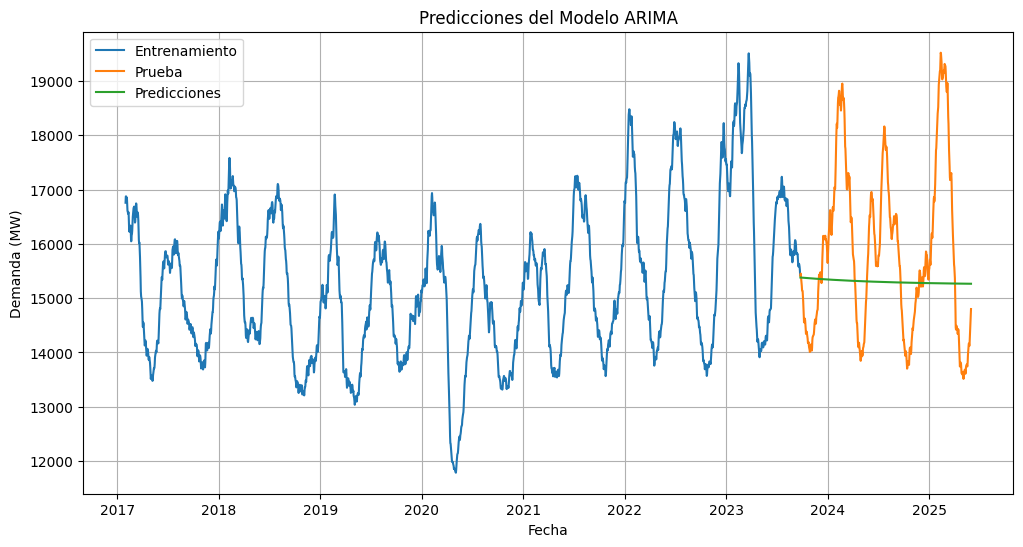

In [16]:
# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='tab:blue')
plt.plot(test.index, test, label='Prueba', color='tab:orange')
plt.plot(predictions.index, predictions, label='Predicciones', color='tab:green')
plt.title('Predicciones del Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid()
plt.show()

In [17]:
# Forecasting lineal con intervalos de confianza
forecast = model_fit.get_forecast(steps=len(test))
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()

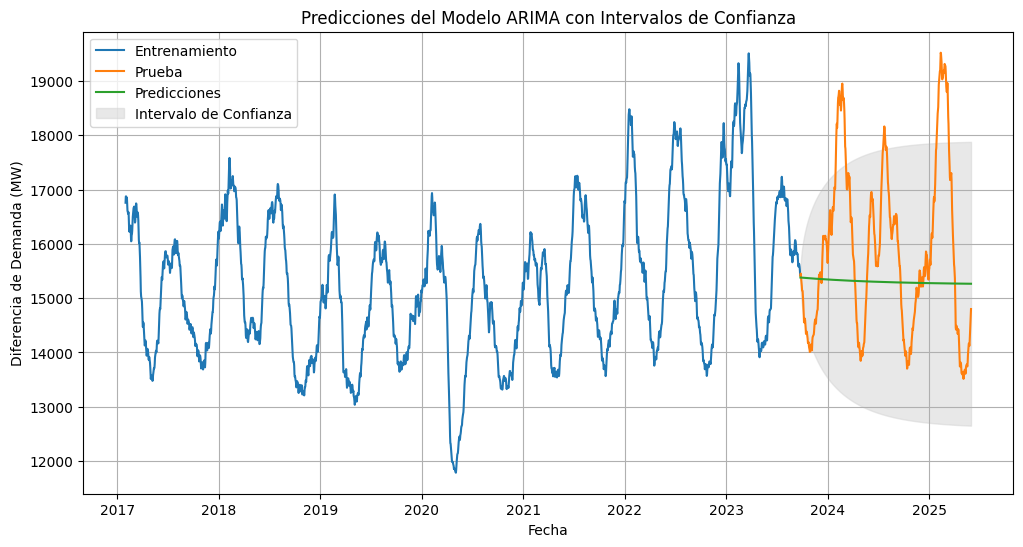

In [18]:
# Visualizar el pronóstico con intervalos de confianza
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='tab:blue')
plt.plot(test.index, test, label='Prueba', color='tab:orange')
plt.plot(forecast_series.index, forecast_series, label='Predicciones', color='tab:green')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:,  1], color='lightgray', alpha=0.5, label='Intervalo de Confianza')
plt.title('Predicciones del Modelo ARIMA con Intervalos de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Demanda (MW)')
plt.legend()
plt.grid()
plt.show()

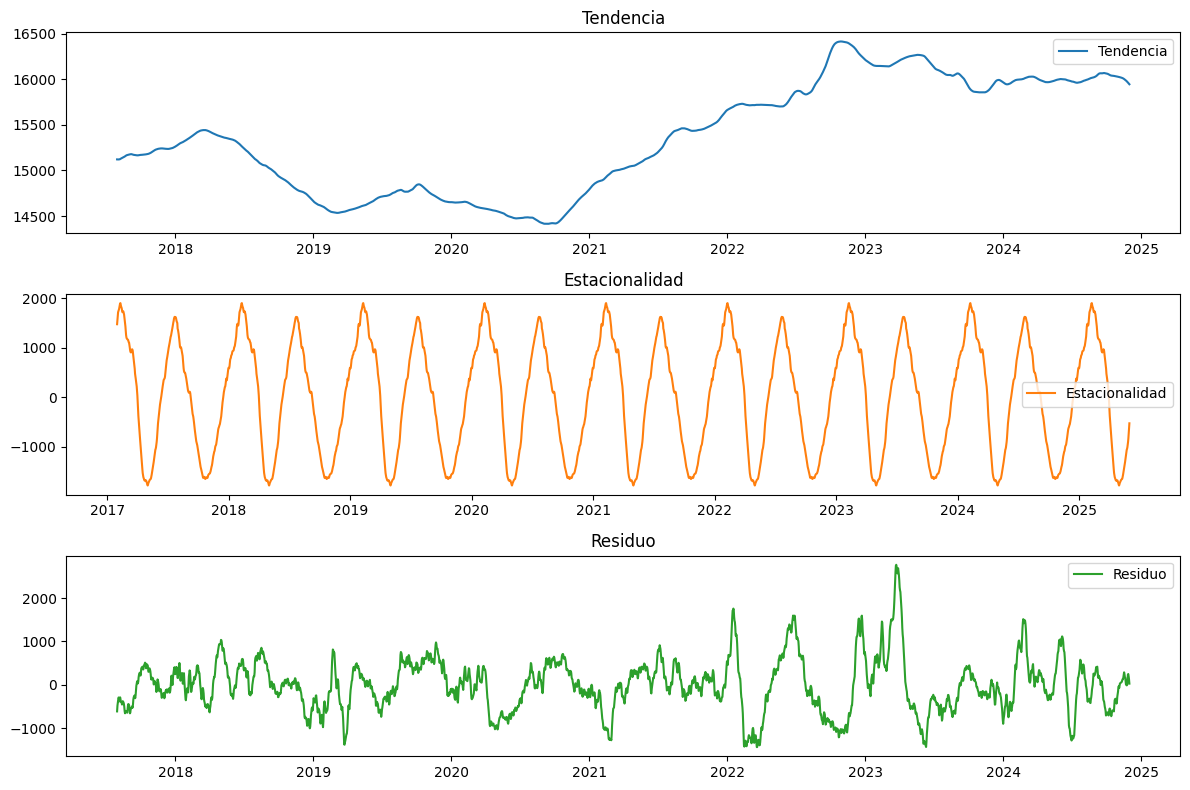

In [19]:
# Descomposicion clásica de tendencia, estacionalidad y ruido
decomposition = seasonal_decompose(data['MA30'].dropna(), model='additive', period=365)
# Descomposición de la serie temporal
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()
# Visualizar la descomposición
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(trend, label='Tendencia', color='tab:blue')
plt.title('Tendencia')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(seasonal, label='Estacionalidad', color='tab:orange')
plt.title('Estacionalidad')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residual, label='Residuo', color='tab:green')
plt.title('Residuo')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Usamos prophet para hacer predicciones
from prophet import Prophet
prophet_data = train.reset_index()[['Fecha', 'MA30']].rename(columns={'Fecha': 'ds', 'MA30': 'y'})
# Crear y ajustar el modelo Prophet
prophet_model = Prophet()
prophet_model.fit(prophet_data)

/home/iann/Desktop/Risk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
19:14:05 - cmdstanpy - INFO - Chain [1] start processing
19:14:08 - cmdstanpy - INFO - Chain [1] done processing


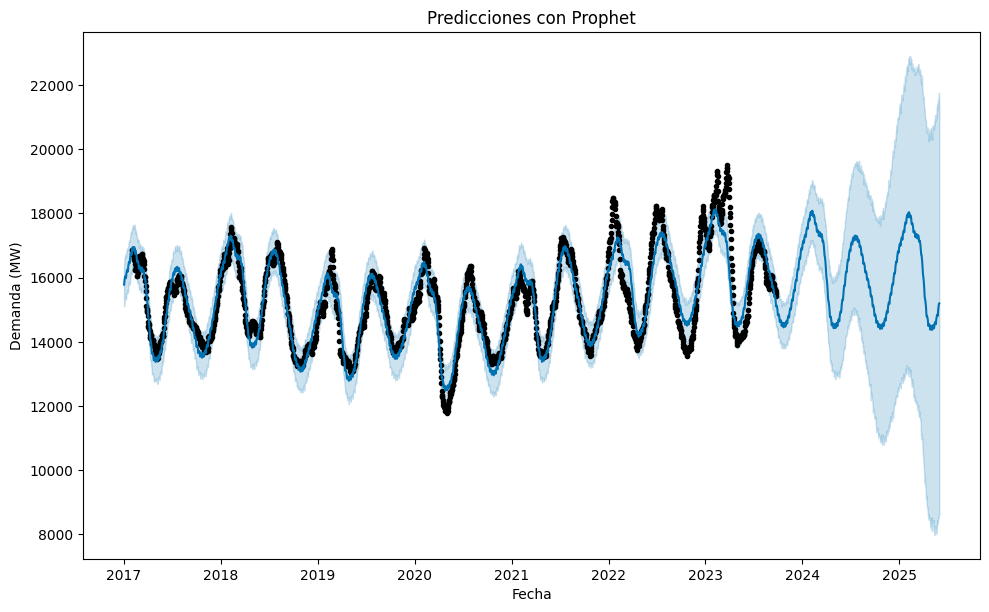

In [21]:
# Visualizar la serie original con la tendencia y estacionalidad
future = prophet_model.make_future_dataframe(periods=test_size)
forecast_prophet = prophet_model.predict(future)
# Visualizar las predicciones de Prophet
fig = prophet_model.plot(forecast_prophet)
plt.title('Predicciones con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.grid()
plt.show()

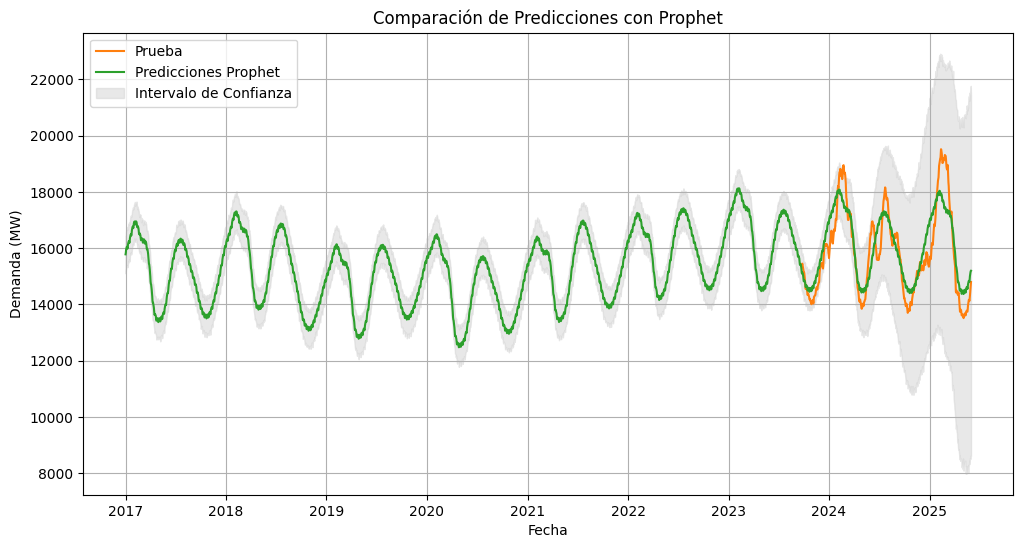

In [22]:
# Comparamos test y predicciones de Prophet
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Prueba', color='tab:orange')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Predicciones Prophet', color='tab:green')
plt.fill_between(forecast_prophet['ds'], 
                 forecast_prophet['yhat_lower'], 
                 forecast_prophet['yhat_upper'], 
                 color='lightgray', alpha=0.5, label='Intervalo de Confianza')
plt.title('Comparación de Predicciones con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Calculamos MSE para las predicciones de Prophet
prophet_predictions = forecast_prophet.set_index('ds')['yhat']
prophet_mse = MSE(test.dropna(), prophet_predictions[test.index].dropna())
print(f"Error Cuadrático Medio (MSE) de Prophet: {prophet_mse:.2f}")
print(f"Error Cuadrático Medio (MSE) de ARIMA: {mse:.2f}")


Error Cuadrático Medio (MSE) de Prophet: 515322.83
Error Cuadrático Medio (MSE) de ARIMA: 2740891.10
